In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

#1 DETECT FACE, HAND AND POSE LANDMARKS

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [7]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [9]:
len(results.right_hand_landmarks.landmark)

21

In [10]:
results

mediapipe.python.solution_base.SolutionOutputs

In [11]:
draw_landmarks(frame, results)

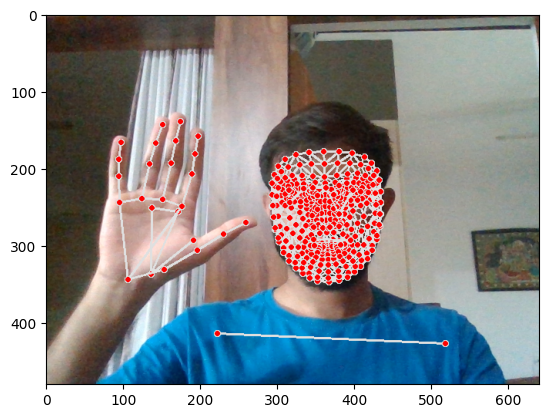

In [12]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

#2 EXTRACT KEYPOINT VALUES

In [13]:
#All the values of landmarks to a 1 dimension array (flatten()) else a blank array of the same number of values
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh]) #Concatenate them all to get a final array which will have all the landmarks

In [14]:
result_test = extract_keypoints(results)

In [15]:
result_test

array([ 0.59441864,  0.53968233, -0.99540174, ...,  0.15222314,
        0.34641829, -0.06444442])

In [16]:
np.save('0', result_test) #to save frames (just to understand)

In [17]:
np.load('0.npy') #load the npy file

array([ 0.59441864,  0.53968233, -0.99540174, ...,  0.15222314,
        0.34641829, -0.06444442])

#3 SETUP FOLDERS FOR DATA COLLECTION

In [18]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [19]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

#4 COLLECT KEYPOINT VALUES FOR TRAINING AND TESTING

In [21]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

#5 PREPROCESS DATA AND CREATE LABLES AND FEATURES

In [22]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [23]:
label_map = {label:num for num, label in enumerate(actions)}

In [24]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [25]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
#Converts data into a 1D-array

In [26]:
np.array(sequences).shape

(90, 30, 1662)

In [27]:
np.array(labels).shape

(90,)

In [28]:
x = np.array(sequences)

In [29]:
x.shape

(90, 30, 1662)

In [30]:
y = to_categorical(labels).astype(int)

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05)

In [32]:
y_test.shape

(5, 3)

#6 BUILD AND TRAIN LSTM NEURAL NETWORK

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [34]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [48]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [50]:
res = [.7, 0.2, 0.1]

In [51]:
actions[np.argmax(res)]

'hello'

In [52]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [55]:
model.fit(x_train, y_train, epochs=100, callbacks=[tb_callback])

Epoch 1/100
3/3 [==============================] - 2s 153ms/step - loss: 0.6618 - categorical_accuracy: 0.7059
Epoch 2/100
3/3 [==============================] - 0s 144ms/step - loss: 0.4890 - categorical_accuracy: 0.7765
Epoch 3/100
3/3 [==============================] - 0s 132ms/step - loss: 0.3927 - categorical_accuracy: 0.8118
Epoch 4/100
3/3 [==============================] - 0s 123ms/step - loss: 0.3652 - categorical_accuracy: 0.8118
Epoch 5/100
3/3 [==============================] - 0s 120ms/step - loss: 0.3602 - categorical_accuracy: 0.8000
Epoch 6/100
3/3 [==============================] - 0s 117ms/step - loss: 0.3859 - categorical_accuracy: 0.7412
Epoch 7/100
3/3 [==============================] - 0s 127ms/step - loss: 0.3864 - categorical_accuracy: 0.7882
Epoch 8/100
3/3 [==============================] - 0s 127ms/step - loss: 0.3926 - categorical_accuracy: 0.7647
Epoch 9/100
3/3 [==============================] - 0s 122ms/step - loss: 0.3409 - categorical_accuracy: 0.8000
E

#7 MAKE PREDICTIONS

In [56]:
res = model.predict(x_test)

1/1 [==============================] - 1s 804ms/step


In [63]:
actions[np.argmax(res[0])]

'thanks'

In [64]:
actions[np.argmax(y_test[0])]

'thanks'

#8 SAVE WEIGHTS

In [65]:
model.save('action.h5')

c:\Users\arjun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
del model

In [ ]:
#To reload the model:
#1 Go to our model rebuild and run it
#2 Then compile the model
#3 Run this cell
model.load_weights('action.h5')

#9 EVALUATION USING CONFUSION MATRIX AND ACCURACY

In [66]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [67]:
yhat = model.predict(x_test)

1/1 [==============================] - 0s 61ms/step


In [68]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [69]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [0, 1]],

       [[1, 0],
        [0, 4]]], dtype=int64)

In [70]:
accuracy_score(ytrue, yhat)

1.0

#10 TEST IN REAL TIME

In [71]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [73]:
type(sequence)

int

In [74]:
sequences.reverse()

In [75]:
len(sequences)

90

In [76]:
sequences.append('def')

In [77]:
sequences.reverse()

In [78]:
sequences[-30:]

[[array([ 0.52824652,  0.3088018 , -1.13766968, ...,  0.53338987,
          0.6319387 , -0.19018048]),
  array([ 0.52985722,  0.30759087, -1.02807462, ...,  0.340462  ,
          0.68622446, -0.06288087]),
  array([ 0.53856862,  0.30763686, -0.933568  , ...,  0.15086317,
          0.5530259 , -0.03383636]),
  array([ 0.54209757,  0.30731794, -0.89318705, ...,  0.12858753,
          0.47586572, -0.03605061]),
  array([ 0.54810578,  0.30522829, -0.92884177, ...,  0.11590514,
          0.2383973 , -0.02844743]),
  array([ 0.56450677,  0.30533585, -0.9544279 , ...,  0.19279179,
          0.20074624, -0.03355309]),
  array([ 0.56626642,  0.30536518, -0.93521243, ...,  0.21793742,
          0.19346732, -0.04653485]),
  array([ 0.56772602,  0.30105153, -0.94087839, ...,  0.22239265,
          0.18089442, -0.04267013]),
  array([ 0.56635481,  0.30039304, -0.95294607, ...,  0.20867184,
          0.18108025, -0.05225679]),
  array([ 0.55570161,  0.300455  , -0.93414849, ...,  0.19464003,
       

In [80]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [81]:
res[np.argmax(res)] > threshold

True

In [82]:
model.predict(np.expand_dims(x_test[0], axis=0))

1/1 [==============================] - 0s 65ms/step


array([[0.00620072, 0.74094796, 0.25285137]], dtype=float32)